## Python version 11.

In [ ]:
!pip install pandas langdetect deep_translator spacy underthesea nltk matplotlib seaborn openpyxl
!python -m spacy download en_core_web_md

In [2]:
# Import các thư viện cần thiết
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
import re
import spacy
from underthesea import word_tokenize, pos_tag
from nltk.corpus import stopwords
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [3]:
nlp_en = spacy.load('en_core_web_md')
stop_words_en = None
stop_words_vi = None

In [53]:
# Đường dẫn đến file csv chứa các job description
csv_jd = "../../data/raw/itviec_jobs_undetected.csv"
stop_words_vn_txt = "../../docs/vietnamese-stopwords.txt"
json_topcv = "../../data/raw/topcv_it_jobs.json"
skills_link = "../../data/skills.txt"

In [31]:
df = pd.read_csv(csv_jd)
df_topcv = pd.read_json(json_topcv)

In [32]:
new_rows = []

for _, json_row in df_topcv.iterrows():
    new_row = {}

    for col in df.columns:
        if col == 'requirements':
            # Nếu cột 'requirements' có tồn tại trong json_row
            if 'requirements' in json_row and isinstance(json_row['requirements'], list):
                new_row[col] = ', '.join(json_row['requirements'])
            else:
                new_row[col] = json_row.get('requirements', None)
        else:
            new_row[col] = json_row.get(col, None)

    new_rows.append(new_row)

# Thêm tất cả dòng mới vào df
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)



In [33]:
with open(stop_words_vn_txt, 'r', encoding='utf-8') as f:
    stop_words_vi = set(word.strip() for word in f if word.strip())
stop_words_en = set(stopwords.words('english'))

In [34]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'


def translate_to_english(text, lang):
    try:
        if lang == 'en' or pd.isna(text) or text.strip() == "":
            return text
        return GoogleTranslator(source=lang, target='en').translate(text)
    except Exception as e:
        print(f"Error translating: {e} | text: {text}")
        return text
def clean_text_not_stopword(text):
    text = text.lower()
    text = re.sub(r'http\S+|#\S+|@\S+|[^\w\s]|\n|\r|\t|\*|\•', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    tokens = text.split()
    cleaned = []

    for token in tokens:
        if token.isupper():
            cleaned.append(token)
            continue
        if token.lower() in stop_words_en or token.lower() in stop_words_vi:
            continue
        cleaned.append(token)
    return ' '.join(cleaned)



def clean_text(text, lang="en"):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    protected = []
    def _protect(match):
        protected.append(match.group(0))
        return f"__PROT_{len(protected)-1}__"
    
    # Bảo vệ các thuật ngữ IT như C#, C++, node.js trước mọi xử lý
    text = re.sub(r"\b\w+[#+.]\w*\b", _protect, text, flags=re.IGNORECASE)
    
    # Các bước xử lý văn bản
    text = text.lower()
    text = re.sub(r"(?<=\b\w)[-/](?=\w\b)", " ", text)
    text = re.sub(r"\s*&\s*", " ", text)
    text = re.sub(r"http\S+|@\s|\s@(?=\s)|\s#", " ", text)
    text = re.sub(r"[()]", " ", text)
    text = re.sub(r"(?<!\w)[.,!?;:–—](?!\w)", " ", text)
    text = re.sub(r"[\n\r\t]", " ", text)
    text = re.sub(r"\b\w*['’‘]\w*\b", "", text)
    text = re.sub(r"\s*[-–—]{2,}\s*", " ", text)
    text = re.sub(r"[“”‘’«»„‟]", " ", text)
    text = re.sub(r"(?<=\w)[.,!:](?=\s|$)", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"/", " ", text)
    text = re.sub(r"(?<=\w):(?=\w)", " ", text)
    text = re.sub(r"([^a-zA-Z0-9\s])\1{2,}", "", text)
    
    
    # Khôi phục các thuật ngữ được bảo vệ
    for i, word in enumerate(protected):
        text = text.replace(f"__prot_{i}__", word.lower())
    
    return text

# Kiểm tra

def clean_skills(text):
    if text == None:
        return text
    text.lower()
    if pd.isna(text) or text.strip() == "":
        return []
    return [t.strip() for t in text.split(',') if t.strip()]

In [35]:
text = f''' we need skils C++, c# and python, node.js, java'''
print(clean_text(text))

we need skils c++ c# and python node.js java


In [36]:
pd.DataFrame(df)

,id,title,company,location,salary,work_type,description,requirements,skills
0,1,MLops Engineer,Trusting Social,Ho Chi Minh,You'll love it,Not specified,We are looking for qualified MLops Engineer fo...,BS or MS in Computer Science or related fields...,"MLOps, Python, Linux, Docker, Data Science, Te..."
1,2,"Senior DevOps Engineer (Cloud, AWS)",TymeX,Ho Chi Minh,You'll love it,Not specified,We are seeking an experienced Senior DevOps En...,Requirements:\nBachelor's or Master's degree i...,"AWS, DevOps, Cloud, Cloud-native Architecture,..."
2,3,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),Viettel Group,Ha Noi,You'll love it,Not specified,Ecotek đang dẫn dắt Ecopark phát triển trở thà...,"Tư duy logic tốt, tư duy hướng giải pháp, tư d...","Project Management, Business Analysis, Presale..."
3,4,VTS - Tư Vấn Giải Pháp - Presales Engineer,Viettel Group,Ha Noi,You'll love it,Not specified,"Gia nhập “vũ trụ” công nghệ Viettel, nơi bạn k...",Bằng cấp: Tốt nghiệp Đại học (loại Khá trở lên...,"Presale, Business Analysis, Salesforce, Pre-sa..."
4,5,"VHT - Embedded Software Engineer (Linux, C++)",Viettel Group,Ha Noi,"650 - 2,200 USD",Not specified,"Với hơn 1200 nhân sự chất lượng cao , Tổng Côn...",Tốt nghiệp Đại học chính quy loại Khá trở lên ...,"Embedded, C++, Linux, C language, Embedded Eng..."
...,...,...,...,...,...,...,...,...,...
2508,None,CTV Quản Lý Dự Án,Công ty CP An ninh mạng Việt Nam,Hà Nội,Thoả thuận,None,--- Mô tả công việc ---\nTheo dõi kế hoạch dự ...,"Kỹ năng giao tiếp, Làm việc nhóm, Quản lý thời...",None
2509,None,Nhân Viên Thiết Kế (Designer),Công Ty TNHH Thương Mại - Dịch Vụ Hoa Mai,Hồ Chí Minh,10 - 15 triệu,None,--- Mô tả công việc ---\n- Chịu trách nhiệm ...,,None
2510,None,Nhân Viên Thiết Kế Đồ Họa,Công ty TNHH GONG CHA VIỆT NAM,Hồ Chí Minh,Thoả thuận,None,--- Mô tả công việc ---\nThiết kế key visuals ...,"Khả Năng Làm Việc Độc Lập Và Nhóm, Khả Năng Sá...",None
2511,None,Trợ Lý Kinh Doanh B2B,CÔNG TY TNHH DỊCH VỤ CÔNG NGHỆ THÔNG TIN HOÀNG...,Hồ Chí Minh,15 - 25 triệu,None,--- Mô tả công việc ---\nVai trò của bạn – Trợ...,"Giao tiếp hiệu quả, Kỹ Năng Tổ Chức Và Quản Lý...",None


In [37]:
# Áp dụng cho cột 'description'
df['language'] = df['description'].apply(detect_language)
df['skills_en'] = df['skills']

In [38]:
df['description_clean'] = df.apply(lambda x: clean_text(x['description']), axis=1)
df['requirements_clean'] = df.apply(lambda x: clean_text(x['requirements']), axis=1)

In [39]:
pd.DataFrame(df)

,id,title,company,location,salary,work_type,description,requirements,skills,language,skills_en,description_clean,requirements_clean
0,1,MLops Engineer,Trusting Social,Ho Chi Minh,You'll love it,Not specified,We are looking for qualified MLops Engineer fo...,BS or MS in Computer Science or related fields...,"MLOps, Python, Linux, Docker, Data Science, Te...",en,"MLOps, Python, Linux, Docker, Data Science, Te...",we are looking for qualified mlops engineer fo...,bs or ms in computer science or related fields...
1,2,"Senior DevOps Engineer (Cloud, AWS)",TymeX,Ho Chi Minh,You'll love it,Not specified,We are seeking an experienced Senior DevOps En...,Requirements:\nBachelor's or Master's degree i...,"AWS, DevOps, Cloud, Cloud-native Architecture,...",en,"AWS, DevOps, Cloud, Cloud-native Architecture,...",we are seeking an experienced senior devops en...,requirements or degree in computer science inf...
2,3,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),Viettel Group,Ha Noi,You'll love it,Not specified,Ecotek đang dẫn dắt Ecopark phát triển trở thà...,"Tư duy logic tốt, tư duy hướng giải pháp, tư d...","Project Management, Business Analysis, Presale...",vi,"Project Management, Business Analysis, Presale...",ecotek đang dẫn dắt ecopark phát triển trở thà...,tư duy logic tốt tư duy hướng giải pháp tư duy...
3,4,VTS - Tư Vấn Giải Pháp - Presales Engineer,Viettel Group,Ha Noi,You'll love it,Not specified,"Gia nhập “vũ trụ” công nghệ Viettel, nơi bạn k...",Bằng cấp: Tốt nghiệp Đại học (loại Khá trở lên...,"Presale, Business Analysis, Salesforce, Pre-sa...",vi,"Presale, Business Analysis, Salesforce, Pre-sa...",gia nhập vũ trụ công nghệ viettel nơi bạn khôn...,bằng cấp tốt nghiệp đại học loại khá trở lên c...
4,5,"VHT - Embedded Software Engineer (Linux, C++)",Viettel Group,Ha Noi,"650 - 2,200 USD",Not specified,"Với hơn 1200 nhân sự chất lượng cao , Tổng Côn...",Tốt nghiệp Đại học chính quy loại Khá trở lên ...,"Embedded, C++, Linux, C language, Embedded Eng...",vi,"Embedded, C++, Linux, C language, Embedded Eng...",với hơn 1200 nhân sự chất lượng cao tổng công ...,tốt nghiệp đại học chính quy loại khá trở lên ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,None,CTV Quản Lý Dự Án,Công ty CP An ninh mạng Việt Nam,Hà Nội,Thoả thuận,None,--- Mô tả công việc ---\nTheo dõi kế hoạch dự ...,"Kỹ năng giao tiếp, Làm việc nhóm, Quản lý thời...",None,vi,None,mô tả công việc theo dõi kế hoạch dự án triển ...,kỹ năng giao tiếp làm việc nhóm quản lý thời g...
2509,None,Nhân Viên Thiết Kế (Designer),Công Ty TNHH Thương Mại - Dịch Vụ Hoa Mai,Hồ Chí Minh,10 - 15 triệu,None,--- Mô tả công việc ---\n- Chịu trách nhiệm ...,,None,vi,None,mô tả công việc - chịu trách nhiệm tạo dựng hì...,
2510,None,Nhân Viên Thiết Kế Đồ Họa,Công ty TNHH GONG CHA VIỆT NAM,Hồ Chí Minh,Thoả thuận,None,--- Mô tả công việc ---\nThiết kế key visuals ...,"Khả Năng Làm Việc Độc Lập Và Nhóm, Khả Năng Sá...",None,vi,None,mô tả công việc thiết kế key visuals cho các c...,khả năng làm việc độc lập và nhóm khả năng sán...
2511,None,Trợ Lý Kinh Doanh B2B,CÔNG TY TNHH DỊCH VỤ CÔNG NGHỆ THÔNG TIN HOÀNG...,Hồ Chí Minh,15 - 25 triệu,None,--- Mô tả công việc ---\nVai trò của bạn – Trợ...,"Giao tiếp hiệu quả, Kỹ Năng Tổ Chức Và Quản Lý...",None,vi,None,mô tả công việc vai trò của bạn trợ lý kinh do...,giao tiếp hiệu quả kỹ năng tổ chức và quản lý ...


In [40]:
df.to_excel('text.xlsx')

In [41]:
df['description_en_clean'] = df.apply(lambda x: translate_to_english(x['description_clean'], x['language']), axis=1)
df['requirements_en_clean'] = df.apply(lambda x: translate_to_english(x['requirements_clean'], x['language']), axis=1)

Error translating: mô tả công việc 1.quản lý vận hành hệ thống cơ sở dữ liệu csdl - tư vấn thiết kế xây dựng csdl;- thiết kế thiết lập các biện pháp tăng cường an ninh bảo mật cho csdl;- thiết kế xây dựng chiến lược sao lưu phục hồi csdl;- thiết kế xây dưng các chương trình script thực hiện giám sát hoạt động csdl phát hiện xử lý ngăn chặn kịp thời các sự cố vấn đề csdl;- nghiên cứu và đánh giá các hệ thống cơ sở dữ liệu và đưa ra các giải pháp tối ưu các biện pháp tinh chỉnh cho cơ sở dữ liệu;- phân tích xác định nguyên nhân các sự cố vấn đề liên quan đến csdl;- cập nhật các bản vá lỗi nâng cấp phiên bản csdl;- chuyển đổi quy hoạch hệ thống csdl tối ưu sử dụng tài nguyên phần cứng máy chủ cũng như đáp ứng yêu cầu hiệu năng của từng hệ thống ứng dụng báo cáo;2 tổ chức triển khai dự án dự án các công việc bảo trì hệ thống csdl tổ chức triển khai các hạng mục công việc của dự án cr theo đúng kế hoạch đã phê duyệt:- tổ chức hỗ trợ thực hiện xây dựng các yêu cầu kỹ thuật liên quan đến csdl

In [48]:
for i in range(len(df)):
    df.at[i, 'id'] = "JOB_" + str(i)


In [43]:
pd.DataFrame(df)

,id,title,company,location,salary,work_type,description,requirements,skills,language,skills_en,description_clean,requirements_clean,description_en_clean,requirements_en_clean
0,JOB_0,MLops Engineer,Trusting Social,Ho Chi Minh,You'll love it,Not specified,We are looking for qualified MLops Engineer fo...,BS or MS in Computer Science or related fields...,"MLOps, Python, Linux, Docker, Data Science, Te...",en,"MLOps, Python, Linux, Docker, Data Science, Te...",we are looking for qualified mlops engineer fo...,bs or ms in computer science or related fields...,we are looking for qualified mlops engineer fo...,bs or ms in computer science or related fields...
1,JOB_1,"Senior DevOps Engineer (Cloud, AWS)",TymeX,Ho Chi Minh,You'll love it,Not specified,We are seeking an experienced Senior DevOps En...,Requirements:\nBachelor's or Master's degree i...,"AWS, DevOps, Cloud, Cloud-native Architecture,...",en,"AWS, DevOps, Cloud, Cloud-native Architecture,...",we are seeking an experienced senior devops en...,requirements or degree in computer science inf...,we are seeking an experienced senior devops en...,requirements or degree in computer science inf...
2,JOB_2,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),Viettel Group,Ha Noi,You'll love it,Not specified,Ecotek đang dẫn dắt Ecopark phát triển trở thà...,"Tư duy logic tốt, tư duy hướng giải pháp, tư d...","Project Management, Business Analysis, Presale...",vi,"Project Management, Business Analysis, Presale...",ecotek đang dẫn dắt ecopark phát triển trở thà...,tư duy logic tốt tư duy hướng giải pháp tư duy...,Ecotek is leading Ecopark to become a smart ci...,Good logical thinking of thinking solutions to...
3,JOB_3,VTS - Tư Vấn Giải Pháp - Presales Engineer,Viettel Group,Ha Noi,You'll love it,Not specified,"Gia nhập “vũ trụ” công nghệ Viettel, nơi bạn k...",Bằng cấp: Tốt nghiệp Đại học (loại Khá trở lên...,"Presale, Business Analysis, Salesforce, Pre-sa...",vi,"Presale, Business Analysis, Salesforce, Pre-sa...",gia nhập vũ trụ công nghệ viettel nơi bạn khôn...,bằng cấp tốt nghiệp đại học loại khá trở lên c...,Joining the Viettel technology space where you...,Graduation degree with a good or higher degree...
4,JOB_4,"VHT - Embedded Software Engineer (Linux, C++)",Viettel Group,Ha Noi,"650 - 2,200 USD",Not specified,"Với hơn 1200 nhân sự chất lượng cao , Tổng Côn...",Tốt nghiệp Đại học chính quy loại Khá trở lên ...,"Embedded, C++, Linux, C language, Embedded Eng...",vi,"Embedded, C++, Linux, C language, Embedded Eng...",với hơn 1200 nhân sự chất lượng cao tổng công ...,tốt nghiệp đại học chính quy loại khá trở lên ...,With more than 1200 high quality personnel Vie...,"Graduated with a regular university or higher,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,JOB_2508,CTV Quản Lý Dự Án,Công ty CP An ninh mạng Việt Nam,Hà Nội,Thoả thuận,None,--- Mô tả công việc ---\nTheo dõi kế hoạch dự ...,"Kỹ năng giao tiếp, Làm việc nhóm, Quản lý thời...",None,vi,None,mô tả công việc theo dõi kế hoạch dự án triển ...,kỹ năng giao tiếp làm việc nhóm quản lý thời g...,Project description of project plan implementa...,Working skills in group management team manage...
2509,JOB_2509,Nhân Viên Thiết Kế (Designer),Công Ty TNHH Thương Mại - Dịch Vụ Hoa Mai,Hồ Chí Minh,10 - 15 triệu,None,--- Mô tả công việc ---\n- Chịu trách nhiệm ...,,None,vi,None,mô tả công việc - chịu trách nhiệm tạo dựng hì...,,Job description - Responsible for creating ima...,
2510,JOB_2510,Nhân Viên Thiết Kế Đồ Họa,Công ty TNHH GONG CHA VIỆT NAM,Hồ Chí Minh,Thoả thuận,None,--- Mô tả công việc ---\nThiết kế key visuals ...,"Khả Năng Làm Việc Độc Lập Và Nhóm, Khả Năng Sá...",None,vi,None,mô tả công việc thiết kế key visuals cho các c...,khả năng làm việc độc lập và nhóm khả năng sán...,Key Visuals design description for online camp...,The ability to work independently and the crea...
2511,JOB_2511,Trợ Lý Kinh Doanh B2B,CÔNG TY TNHH DỊCH VỤ CÔNG NGHỆ THÔNG TIN HOÀNG...,Hồ Chí Minh,15 - 25 triệu,None,--- Mô tả công

In [44]:
df = df[~df['description'].str.lower().str.strip().isin(['', 'no description available','not specified'])]
df = df[~df['requirements'].str.lower().str.strip().isin(['', 'no requirements specified','not specified'])]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2081 entries, 0 to 2512
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2081 non-null   object
 1   title                  2081 non-null   object
 2   company                2081 non-null   object
 3   location               2081 non-null   object
 4   salary                 2081 non-null   object
 5   work_type              841 non-null    object
 6   description            2081 non-null   object
 7   requirements           2081 non-null   object
 8   skills                 841 non-null    object
 9   language               2081 non-null   object
 10  skills_en              841 non-null    object
 11  description_clean      2081 non-null   object
 12  requirements_clean     2081 non-null   object
 13  description_en_clean   2081 non-null   object
 14  requirements_en_clean  2081 non-null   object
dtypes: object(15)
memory usage

In [46]:
drop_columns = ['skills','skills_en']
df = df.drop(drop_columns, axis=1)

In [56]:
def read_skills(file_path):
    skills = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                skills.append(line.lower())
    return skills

skills_list = read_skills('../../data/skills.txt')

In [69]:
import re
from collections import Counter
import spacy

adj_counter = Counter()
adv_counter = Counter()

def clean_text_for_matching(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    protected = []
    def _protect(match):
        protected.append(match.group(0))
        return f"__PROT_{len(protected)-1}__"
    
    # Bảo vệ các thuật ngữ IT như C#, C++, node.js trước mọi xử lý
    text = re.sub(r"\b\w+[#+.]\w*\b", _protect, text, flags=re.IGNORECASE)
    
    # Các bước xử lý văn bản
    text = text.lower()
    text = re.sub(r"(?<=\b\w)[-/](?=\w\b)", " ", text)
    text = re.sub(r"\s*&\s*", " ", text)
    text = re.sub(r"http\S+|@\s|\s@(?=\s)|\s#", " ", text)
    text = re.sub(r"[()]", " ", text)
    text = re.sub(r"(?<!\w)[.,!?;:–—](?!\w)", " ", text)
    text = re.sub(r"[\n\r\t]", " ", text)
    text = re.sub(r"\b\w*['’‘]\w*\b", "", text)
    text = re.sub(r"\s*[-–—]{2,}\s*", " ", text)
    text = re.sub(r"[“”‘’«»„‟]", " ", text)
    text = re.sub(r"(?<=\w)[.,!:](?=\s|$)", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"/", " ", text)
    text = re.sub(r"(?<=\w):(?=\w)", " ", text)
    text = re.sub(r"([^a-zA-Z0-9\s])\1{2,}", "", text)
    
    
    # Khôi phục các thuật ngữ được bảo vệ
    for i, word in enumerate(protected):
        text = text.replace(f"__prot_{i}__", word.lower())
    
    return text

def nomalize_skills(skills):
    return [clean_text_for_matching(skill).strip() for skill in skills]


skills_list = nomalize_skills(skills_list)
def generate_ngrams(text, max_n=3):
    tokens = text.split()
    ngrams = []
    for n in range(1, max_n+1):
        ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
    return ngrams

def extract_skills(text):
    if not isinstance(text.lower(), str) or pd.isna(text.lower()):
        return []

    ngrams = generate_ngrams(text.lower(), max_n=3)

    found = [skill for skill in skills_list if skill in ngrams]

    return list(dict.fromkeys(found))



def extract_adjectives(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp_en(text)
    adjs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADJ"
        and len(token.lemma_) > 2            # loại từ ngắn như "as", "own"
        and token.is_alpha                   # bỏ từ chứa số, ký hiệu
        and not token.is_stop                # loại stop words mặc định của spaCy
    ]
    adj_counter.update(adjs)
    return list(set(adjs))

def extract_adverbs(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp_en(text)
    advs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADV"
        and len(token.lemma_) > 2
        and token.is_alpha
        and not token.is_stop
    ]
    adv_counter.update(advs)
    return list(set(advs))

In [68]:
nomalize_skills(['c#','PYTHON','PhP','Node.JS','Java'])

['c#', 'python', 'php', 'node.js', 'java']

In [70]:
df.loc[:, 'primary_skills'] = df.apply(
    lambda row: extract_skills(f"{row['requirements_en_clean'] or ''}"),
    axis=1
)

df.loc[:, 'secondary_skills'] = df.apply(
    lambda row: extract_skills(f"{row['description_en_clean'] or ''}"),
    axis=1
)

df.loc[:, 'adjectives'] = df.apply(
    lambda row: extract_adjectives(f"{row['requirements_en_clean'] or ''} {row['description_en_clean'] or ''}"),
    axis=1
)

df.loc[:, 'adverbs'] = df.apply(
    lambda row: extract_adverbs(f"{row['requirements_en_clean'] or ''} {row['description_en_clean'] or ''}"),
    axis=1
)


In [71]:
df.to_excel('text.xlsx')

C:\Users\ACER ASPIRE\AppData\Local\Temp\ipykernel_15068\1403453381.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')


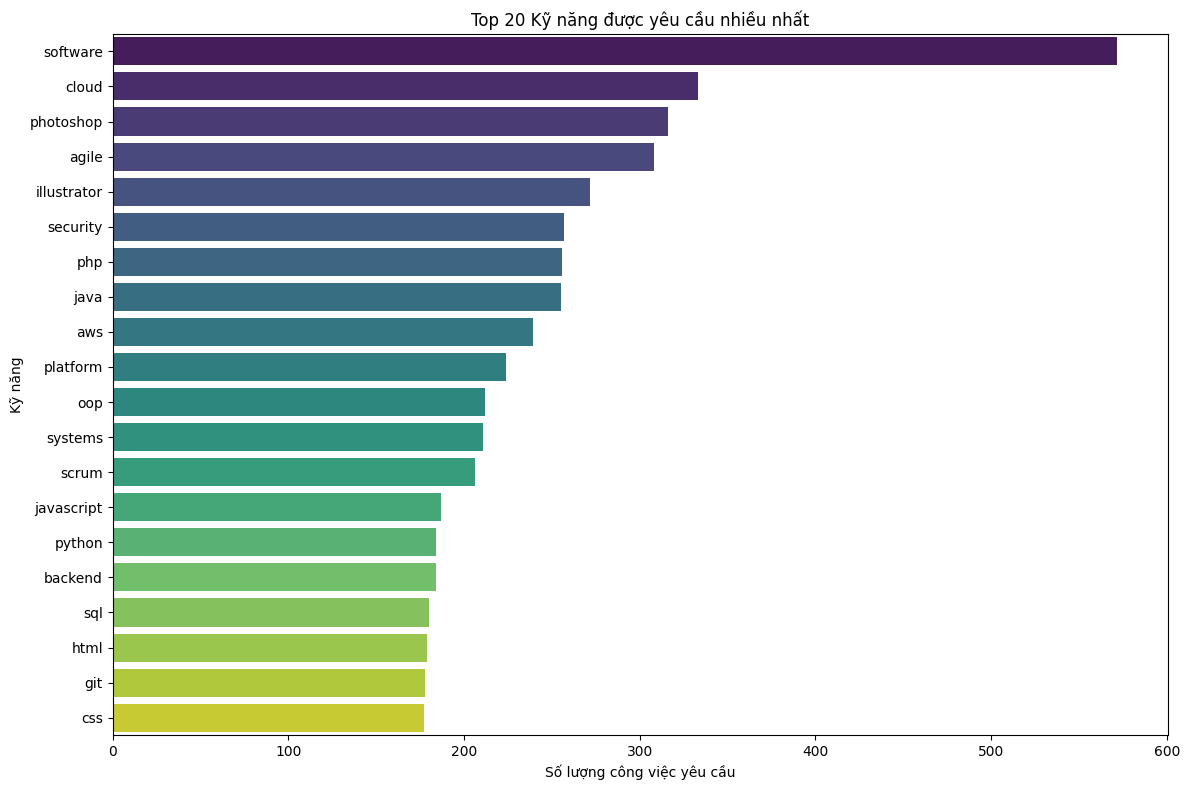

In [72]:
skills_series = df['primary_skills'].explode().dropna().str.strip()

# Đếm kỹ năng phổ biến nhất
skill_counts = Counter(skills_series)
top_skills = skill_counts.most_common(20)

# Chuyển thành DataFrame để vẽ biểu đồ
skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')
plt.title('Top 20 Kỹ năng được yêu cầu nhiều nhất')
plt.xlabel('Số lượng công việc yêu cầu')
plt.ylabel('Kỹ năng')
plt.tight_layout()
plt.show()

In [42]:
pd.DataFrame(df)

,id,title,company,location,salary,description,requirements,skills,language,skills_en,...,requirements_en,description_cleaned,requirements_cleaned,skills_cleaned,location_group,type_salary,primary_skills,secondary_skills,adjectives,adverbs
0,JOB_0,MLops Engineer,Trusting Social,Ho Chi Minh,You'll love it,looking qualified mlops engineer ekyc project ...,bs ms computer science related fields 1 3 year...,"MLOps, Python, Linux, Docker, Data Science, Te...",en,"MLOps, Python, Linux, Docker, Data Science, Te...",...,bs ms computer science related fields 1 3 year...,looking qualified mlops engineer ekyc project ...,bs ms computer science related fields 1 3 year...,"[MLOps, Python, Linux, Docker, Data Science, T...",2,5,"[python, java, javascript, c, tensorflow, pyto...","[git, docker, linux]","[qualified, basic, great, novel, tiny, familia...",[]
1,JOB_1,"Senior DevOps Engineer (Cloud, AWS)",TymeX,Ho Chi Minh,You'll love it,seeking experienced senior devops engineer aws...,requirements degree computer science informati...,"AWS, DevOps, Cloud, Cloud-native Architecture,...",en,"AWS, DevOps, Cloud, Cloud-native Architecture,...",...,requirements degree computer science informati...,seeking experienced senior devops engineer aws...,requirements degree computer science informati...,"[AWS, DevOps, Cloud, Cloud-native Architecture...",2,5,"[python, bash, aws, software, ci cd, devops, d...","[git, gitlab, git flow, docker, jenkins, teamc...","[ansible, continuous, main, periodic, agile, n...","[occasionally, effectively, quickly, independe..."
2,JOB_2,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),Viettel Group,Ha Noi,You'll love it,ecotek dắt ecopark phát triển trở thành mô hìn...,tư logic tư hướng giải pháp tư phản biện kỹ nă...,"Project Management, Business Analysis, Presale...",vi,"Project Management, Business Analysis, Presale...",...,Private Logic Private solutions to criticize c...,ecotek dắt ecopark phát triển trở thành mô hìn...,tư logic tư hướng giải pháp tư phản biện kỹ nă...,"[Project Management, Business Analysis, Presal...",1,5,"[software, network, sales, production]",[],"[private, technical, lightweight, specific, im...","[directly, currently]"
3,JOB_3,VTS - Tư Vấn Giải Pháp - Presales Engineer,Viettel Group,Ha Noi,You'll love it,gia nhập vũ trụ công nghệ viettel đắm chìm hàn...,nghiệp đại học trở chuyên ngành cntt điện tử v...,"Presale, Business Analysis, Salesforce, Pre-sa...",vi,"Presale, Business Analysis, Salesforce, Pre-sa...",...,University of Electronics and Telecommunicatio...,gia nhập vũ trụ công nghệ viettel đắm chìm hàn...,nghiệp đại học trở chuyên ngành cntt điện tử v...,"[Presale, Business Analysis, Salesforce, Pre-s...",1,5,"[cloud, blockchain, iot]",[],"[important, technical, suitable, genuine, spec...",[boldly]
4,JOB_4,"VHT - Embedded Software Engineer (Linux, C++)",Viettel Group,Ha Noi,"650 - 2,200 USD",1200 nhân chất tổng công ty công nghiệp công n...,nghiệp đại học quy trở chuyên ngành công nghệ ...,"Embedded, C++, Linux, C language, Embedded Eng...",vi,"Embedded, C++, Linux, C language, Embedded Eng...",...,"University of University, specialized in telec...",1200 nhân chất tổng công ty công nghiệp công n...,nghiệp đại học quy trở chuyên ngành công nghệ ...,"[Embedded, C++, Linux, C language, Embedded En...",1,2,"[c, systems]",[],"[triển, electronic, human]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,JOB_2508,CTV Quản Lý Dự Án,Công ty CP An ninh mạng Việt Nam,Hà Nội,Thoả thuận,mô tả công dõi kế hoạch dự án triển khai kiểm ...,kỹ năng giao tiếp quản lý thời gian quản lý ng...,,vi,None,...,Communication skills management time for risk ...,mô tả công dõi kế hoạch dự án triển khai kiểm ...,kỹ năng giao tiếp quản lý thời gian quản lý ng...,None,3,5,[],[],"[happy, medium]","[openly, online]"
2509,JOB_2509,Nhân Viên Thiết Kế (Designer),Công Ty TNHH Thương Mại - Dịch Vụ Hoa Mai,Hồ Chí Minh,10 - 15 triệu,mô tả công - trách nhiệm dựng hình ảnh thiết k...,,,vi,Non

In [73]:
df.to_csv('../../data/clean/clean_jobs_v2.csv', index=False, encoding='utf-8')